In [1]:
import sys
sys.path.append('/home/linxuangao')  # 确保父目录在 Python 路径中

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import torch
import umap
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import scipy

from GPNSF.model import GPNSFModel
from GPNSF.utils import *


import warnings
warnings.filterwarnings("ignore")

/home/linxuangao/.conda/envs/glx/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
gpu_id = 4
torch.cuda.set_device(gpu_id)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

print(f'Using device: {device}')
print(f'Current GPU: {torch.cuda.current_device()}')

Using device: cuda
Current GPU: 4


In [4]:
data_dir = '/home/linxuangao/data_gpnsf/MISAR_seq'

In [5]:
# adata1 = sc.read_h5ad(f'{data_dir}/E11_0-S1_expr_gt.h5ad')
# adata2 = sc.read_h5ad(f'{data_dir}/E11_0-S1_atac_gt.h5ad')
# adata1 = sc.read_h5ad(f'{data_dir}/E13_5-S1_expr_gt.h5ad')
# adata2 = sc.read_h5ad(f'{data_dir}/E13_5-S1_atac_gt.h5ad')
adata1 = sc.read_h5ad(f'{data_dir}/E15_5-S1_expr_gt.h5ad')
adata2 = sc.read_h5ad(f'{data_dir}/E15_5-S1_atac_gt.h5ad')

In [6]:
print(adata1.X.shape, adata2.X.shape)  # (N, D1), (N, D2)
print(adata1)
print(adata1.obs['Ground Truth'][:10])

(1949, 32285) (1949, 265014)
AnnData object with n_obs × n_vars = 1949 × 32285
    obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nU

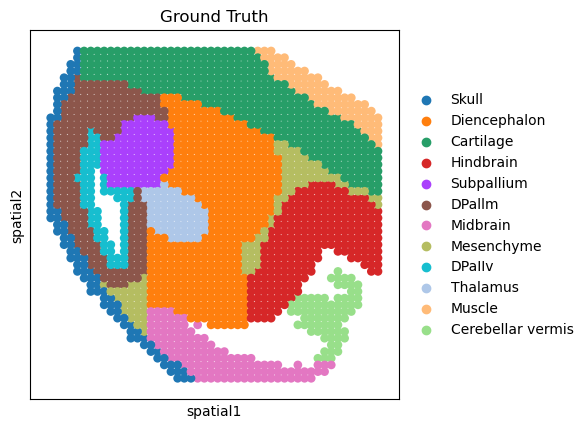

In [7]:
sc.pl.spatial(adata1, color='Ground Truth', spot_size=1.3, title='Ground Truth')

In [8]:
def preprocess_multiome_data(adata_rna, adata_atac, 
                             rna_n_features=3000,
                             atac_n_features=5000):
    """多组学数据预处理流程"""
    
    print("=" * 50)
    print("RNA数据预处理")
    print("=" * 50)
    
    # RNA数据预处理
    # 1. 基本质量控制
    sc.pp.filter_genes(adata_rna, min_counts=50)
    print(f"RNA: 过滤后基因数: {adata_rna.n_vars}")
    
    # 2. 选择高变基因
    sc.pp.highly_variable_genes(
        adata_rna, 
        n_top_genes=rna_n_features,
        flavor='seurat_v3'
    )
    adata_rna = adata_rna[:, adata_rna.var['highly_variable']].copy()
    print(f"RNA: 选择 {adata_rna.n_vars} 个高变基因")
    
    # 3. 标准化
    sc.pp.normalize_total(adata_rna, target_sum=1e4)
    sc.pp.log1p(adata_rna)
    
    print("\n" + "=" * 50)
    print("ATAC数据预处理")
    print("=" * 50)
    
    # ATAC数据预处理
    # 1. 基本质量控制
    sc.pp.filter_genes(adata_atac, min_cells=100)
    print(f"ATAC: 过滤后peak数: {adata_atac.n_vars}")
    
    # 2. 选择高变peak
    sc.pp.highly_variable_genes(
        adata_atac, 
        n_top_genes=atac_n_features,
        flavor='seurat_v3'
    )
    adata_atac = adata_atac[:, adata_atac.var['highly_variable']].copy()
    print(f"ATAC: 选择 {adata_atac.n_vars} 个高变peak")
    
    # # 3. 标准化（ATAC通常使用TF-IDF）
    # from sklearn.feature_extraction.text import TfidfTransformer
    
    # if scipy.sparse.issparse(adata_atac.X):
    #     X = adata_atac.X.toarray()
    # else:
    #     X = adata_atac.X
    
    # tfidf = TfidfTransformer()
    # adata_atac.X = tfidf.fit_transform(X)
    
    print("\n预处理完成!")
    print(f"RNA矩阵大小: {adata_rna.shape}")
    print(f"ATAC矩阵大小: {adata_atac.shape}")
    
    return adata_rna, adata_atac

# 使用示例
adata1_filtered, adata2_filtered = preprocess_multiome_data(
    adata1.copy(), adata2.copy(),
    rna_n_features=4500,
    atac_n_features=2000
)

RNA数据预处理
RNA: 过滤后基因数: 14030
RNA: 选择 4501 个高变基因

ATAC数据预处理
ATAC: 过滤后peak数: 49675
ATAC: 选择 2000 个高变peak

预处理完成!
RNA矩阵大小: (1949, 4501)
ATAC矩阵大小: (1949, 2000)


In [9]:
X_1 = adata1_filtered.X
p = X_1.shape[1]
X_2 = adata2_filtered.X
q = X_2.shape[1]
S = adata1.obsm['spatial']

# del adata1, adata2  # 释放内存

In [10]:
# X_2 = X_2.toarray()
# X_2 = np.where(X_2 != 0.0, 1.0, X_2)
# print(X_2[1,:1000])

In [11]:
K = 20
M = 1000

In [12]:
import scipy.sparse as sp

def to_torch_tensor(x, device, dtype=torch.float32):
    if hasattr(x, "toarray"):
        x = x.toarray()  # scipy.sparse -> ndarray
    if isinstance(x, np.ndarray):
        return torch.as_tensor(x, dtype=dtype, device=device)
    if isinstance(x, torch.Tensor):
        return x.to(device=device, dtype=dtype)
    raise TypeError(f"Unsupported type: {type(x)}")

S_t = to_torch_tensor(S, device, dtype=torch.float32)
X1_t = to_torch_tensor(X_1, device, dtype=torch.float32)
X2_t = to_torch_tensor(X_2, device, dtype=torch.float32)

print('Converted ->', 'S:', S_t.shape, 'X1:', X1_t.shape, 'X2:', X2_t.shape, 'device=', device)

Converted -> S: torch.Size([1949, 2]) X1: torch.Size([1949, 4501]) X2: torch.Size([1949, 2000]) device= cuda


In [13]:
from tqdm import tqdm
# 构建模型与训练循环（周期性打印 loss/ELBO/KL）
model = GPNSFModel(S=S_t, p=p, q=q, K=K, M=M, eta=15.0, num_mc_samples=3, likelihood_x2='poi', 
                   omega_type='chol', kernel_type='matern32').to(device)

# 修改1: 初始学习率设为1e-3
opt = torch.optim.Adam(model.parameters(), lr=1e-2)  # 原为 lr=5e-4

@torch.no_grad()
def compute_loglik_terms(model, X1, X2):
    # 与模型内部保持一致的 Monte Carlo 估计，并适配 X2 的两种似然模式
    W1, W2 = model.get_W1_W2()
    theta1 = model.theta1
    Hs = model.sample_H()  # (S, n, K)
    loglik1 = []
    loglik2 = []
    if model.likelihood_x2 == 'nb':
        lambda2_nb = model.lambda2_nb
    elif model.likelihood_x2 == 'bernoulli':
        lambda2_ber = model.lambda2_ber
        X2_bin = (X2 > 0).to(X2.dtype)
    else:
        lambda2_poi = model.lambda2_poi
    for t in range(Hs.size(0)):
        H = Hs[t]
        Y1 = torch.exp(H) @ W1
        Y2 = torch.exp(H) @ W2
        loglik1.append(nb_log_prob(X1, Y1, theta1).sum())
        if model.likelihood_x2 == 'nb':
            loglik2.append(nb_log_prob(X2, Y2, lambda2_nb).sum())
        elif model.likelihood_x2 == 'ber':
            p2 = torch.clamp(Y2 * lambda2_ber, min=1e-8, max=1.0 - 1e-8)
            loglik2.append(bernoulli_log_prob(X2_bin, p2).sum())
        else:    
            loglik2.append(poisson_log_prob(X2, Y2*lambda2_poi).sum())
    loglik1 = torch.stack(loglik1).mean()
    loglik2 = torch.stack(loglik2).mean()
    return loglik1, loglik2

num_steps = 6000
print_every = 500

# 修改2: 计算切换学习率的步数
switch_step = int(num_steps * 0.7)  # 前40%步数后切换

for step in tqdm(range(1, num_steps + 1), total=num_steps):
    opt.zero_grad()
    loss = model(X1_t, X2_t)  # 负ELBO
    loss.backward()
    opt.step()

    # 修改3: 在达到切换步数时降低学习率
    if step == switch_step:
        for param_group in opt.param_groups:
            param_group['lr'] = 1e-3
        print(f"\n[step {step:03d}] Learning rate changed to 1e-3")

    if step == 1 or step % print_every == 0:
        with torch.no_grad():
            elbo_val = model.elbo(X1_t, X2_t)
            kl_val = model.compute_KL_u()
            loglik1, loglik2 = compute_loglik_terms(model, X1_t, X2_t)
            current_lr = opt.param_groups[0]['lr']  # 添加显示当前学习率
            print(f"[step {step:03d}] loss={loss.item():.3f}  ELBO={elbo_val.item():.3f}  "
                  f"KL={kl_val.item():.3f}  loglik1={loglik1.item():.3f}  "
                  f"loglik2={loglik2.item():.3f}  lr={current_lr:.1e}")  # 添加学习率显示

print('Training finished.')

  0%|          | 1/6000 [00:00<1:21:00,  1.23it/s]

[step 001] loss=14790884.000  ELBO=-14489567.000  KL=3809.985  loglik1=-9113000.000  loglik2=-5295556.000  lr=1.0e-02


  8%|▊         | 500/6000 [02:27<35:13,  2.60it/s]

[step 500] loss=9944001.000  ELBO=-9918681.000  KL=9375.417  loglik1=-6569611.000  loglik2=-3230052.000  lr=1.0e-02


 17%|█▋        | 1000/6000 [04:59<31:46,  2.62it/s]

[step 1000] loss=9186281.000  ELBO=-9194254.000  KL=8972.250  loglik1=-6321419.000  loglik2=-2732784.000  lr=1.0e-02


 25%|██▌       | 1500/6000 [07:30<25:51,  2.90it/s]

[step 1500] loss=9036310.000  ELBO=-9044844.000  KL=7902.821  loglik1=-6267956.000  loglik2=-2664742.000  lr=1.0e-02


 33%|███▎      | 2000/6000 [09:57<22:02,  3.03it/s]

[step 2000] loss=8974910.000  ELBO=-8979270.000  KL=7122.812  loglik1=-6238219.000  loglik2=-2627597.500  lr=1.0e-02


 42%|████▏     | 2500/6000 [12:12<29:09,  2.00it/s]

[step 2500] loss=8929441.000  ELBO=-8930863.000  KL=6570.454  loglik1=-6220487.000  loglik2=-2613060.500  lr=1.0e-02


 50%|█████     | 3000/6000 [14:24<15:15,  3.28it/s]

[step 3000] loss=8901559.000  ELBO=-8904611.000  KL=6222.850  loglik1=-6206874.000  loglik2=-2603399.250  lr=1.0e-02


 58%|█████▊    | 3500/6000 [16:38<14:16,  2.92it/s]

[step 3500] loss=8884283.000  ELBO=-8886200.000  KL=5960.503  loglik1=-6198969.000  loglik2=-2600433.000  lr=1.0e-02


 67%|██████▋   | 4000/6000 [18:55<10:25,  3.20it/s]

[step 4000] loss=8874019.000  ELBO=-8871283.000  KL=5776.317  loglik1=-6190824.000  loglik2=-2600064.000  lr=1.0e-02


 70%|███████   | 4200/6000 [19:48<07:21,  4.08it/s]


[step 4200] Learning rate changed to 1e-3


 75%|███████▌  | 4500/6000 [21:07<08:19,  3.00it/s]

[step 4500] loss=8861216.000  ELBO=-8865441.000  KL=5623.789  loglik1=-6185381.500  loglik2=-2592254.500  lr=1.0e-03


 83%|████████▎ | 5000/6000 [23:19<05:26,  3.06it/s]

[step 5000] loss=8861626.000  ELBO=-8861178.000  KL=5604.538  loglik1=-6187292.000  loglik2=-2590194.750  lr=1.0e-03


 92%|█████████▏| 5500/6000 [25:42<02:45,  3.02it/s]

[step 5500] loss=8861776.000  ELBO=-8858668.000  KL=5584.260  loglik1=-6187099.500  loglik2=-2589643.750  lr=1.0e-03


100%|██████████| 6000/6000 [28:41<00:00,  3.48it/s]

[step 6000] loss=8861146.000  ELBO=-8855632.000  KL=5563.669  loglik1=-6182458.000  loglik2=-2591567.250  lr=1.0e-03
Training finished.


In [14]:
with torch.no_grad():
    n = S_t.size(0)
    K_model = model.K
    H_mu = torch.empty(n, K_model, device=S_t.device, dtype=S_t.dtype)
    for k_idx in range(K_model):
        mu_k, _ = model.q_h_params(k_idx)  # (n,), (n,)
        H_mu[:, k_idx] = mu_k
    H_exp = torch.exp(H_mu)

print('H_mu/H_exp shapes ->', H_mu.shape, H_exp.shape)

H_mu_np = H_mu.detach().cpu().numpy()
H_exp_np = H_exp.detach().cpu().numpy()

H_mu/H_exp shapes -> torch.Size([1949, 20]) torch.Size([1949, 20])


In [15]:
# 先删除所有以'Factor_'开头的列
factor_cols = [col for col in adata1.obs.columns if col.startswith('Factor_')]
adata1.obs = adata1.obs.drop(columns=factor_cols)

# H_exp_np_normalized = H_exp_np

# row_norms = np.linalg.norm(H_exp_np, axis=1, keepdims=True)
# H_exp_np_normalized = H_exp_np / row_norms

row_sums = H_exp_np.sum(axis=1, keepdims=True)
H_exp_np_normalized = H_exp_np / row_sums


# row_sums = H_exp_np.sum(axis=1, keepdims=True)
# row_means = row_sums / H_exp_np.shape[1]
# threshold = 1.0 * row_means
# H_exp_np_filtered = np.where(H_exp_np < threshold, 0, H_exp_np)
# row_sums_filtered = H_exp_np_filtered.sum(axis=1, keepdims=True)
# H_exp_np_normalized = H_exp_np_filtered / row_sums_filtered


temp = pd.DataFrame(H_exp_np_normalized, columns=[f'Factor_{k+1}' for k in range(H_exp_np_normalized.shape[1])])
temp.index = adata1.obs.index
adata1.obs = adata1.obs.join(temp)

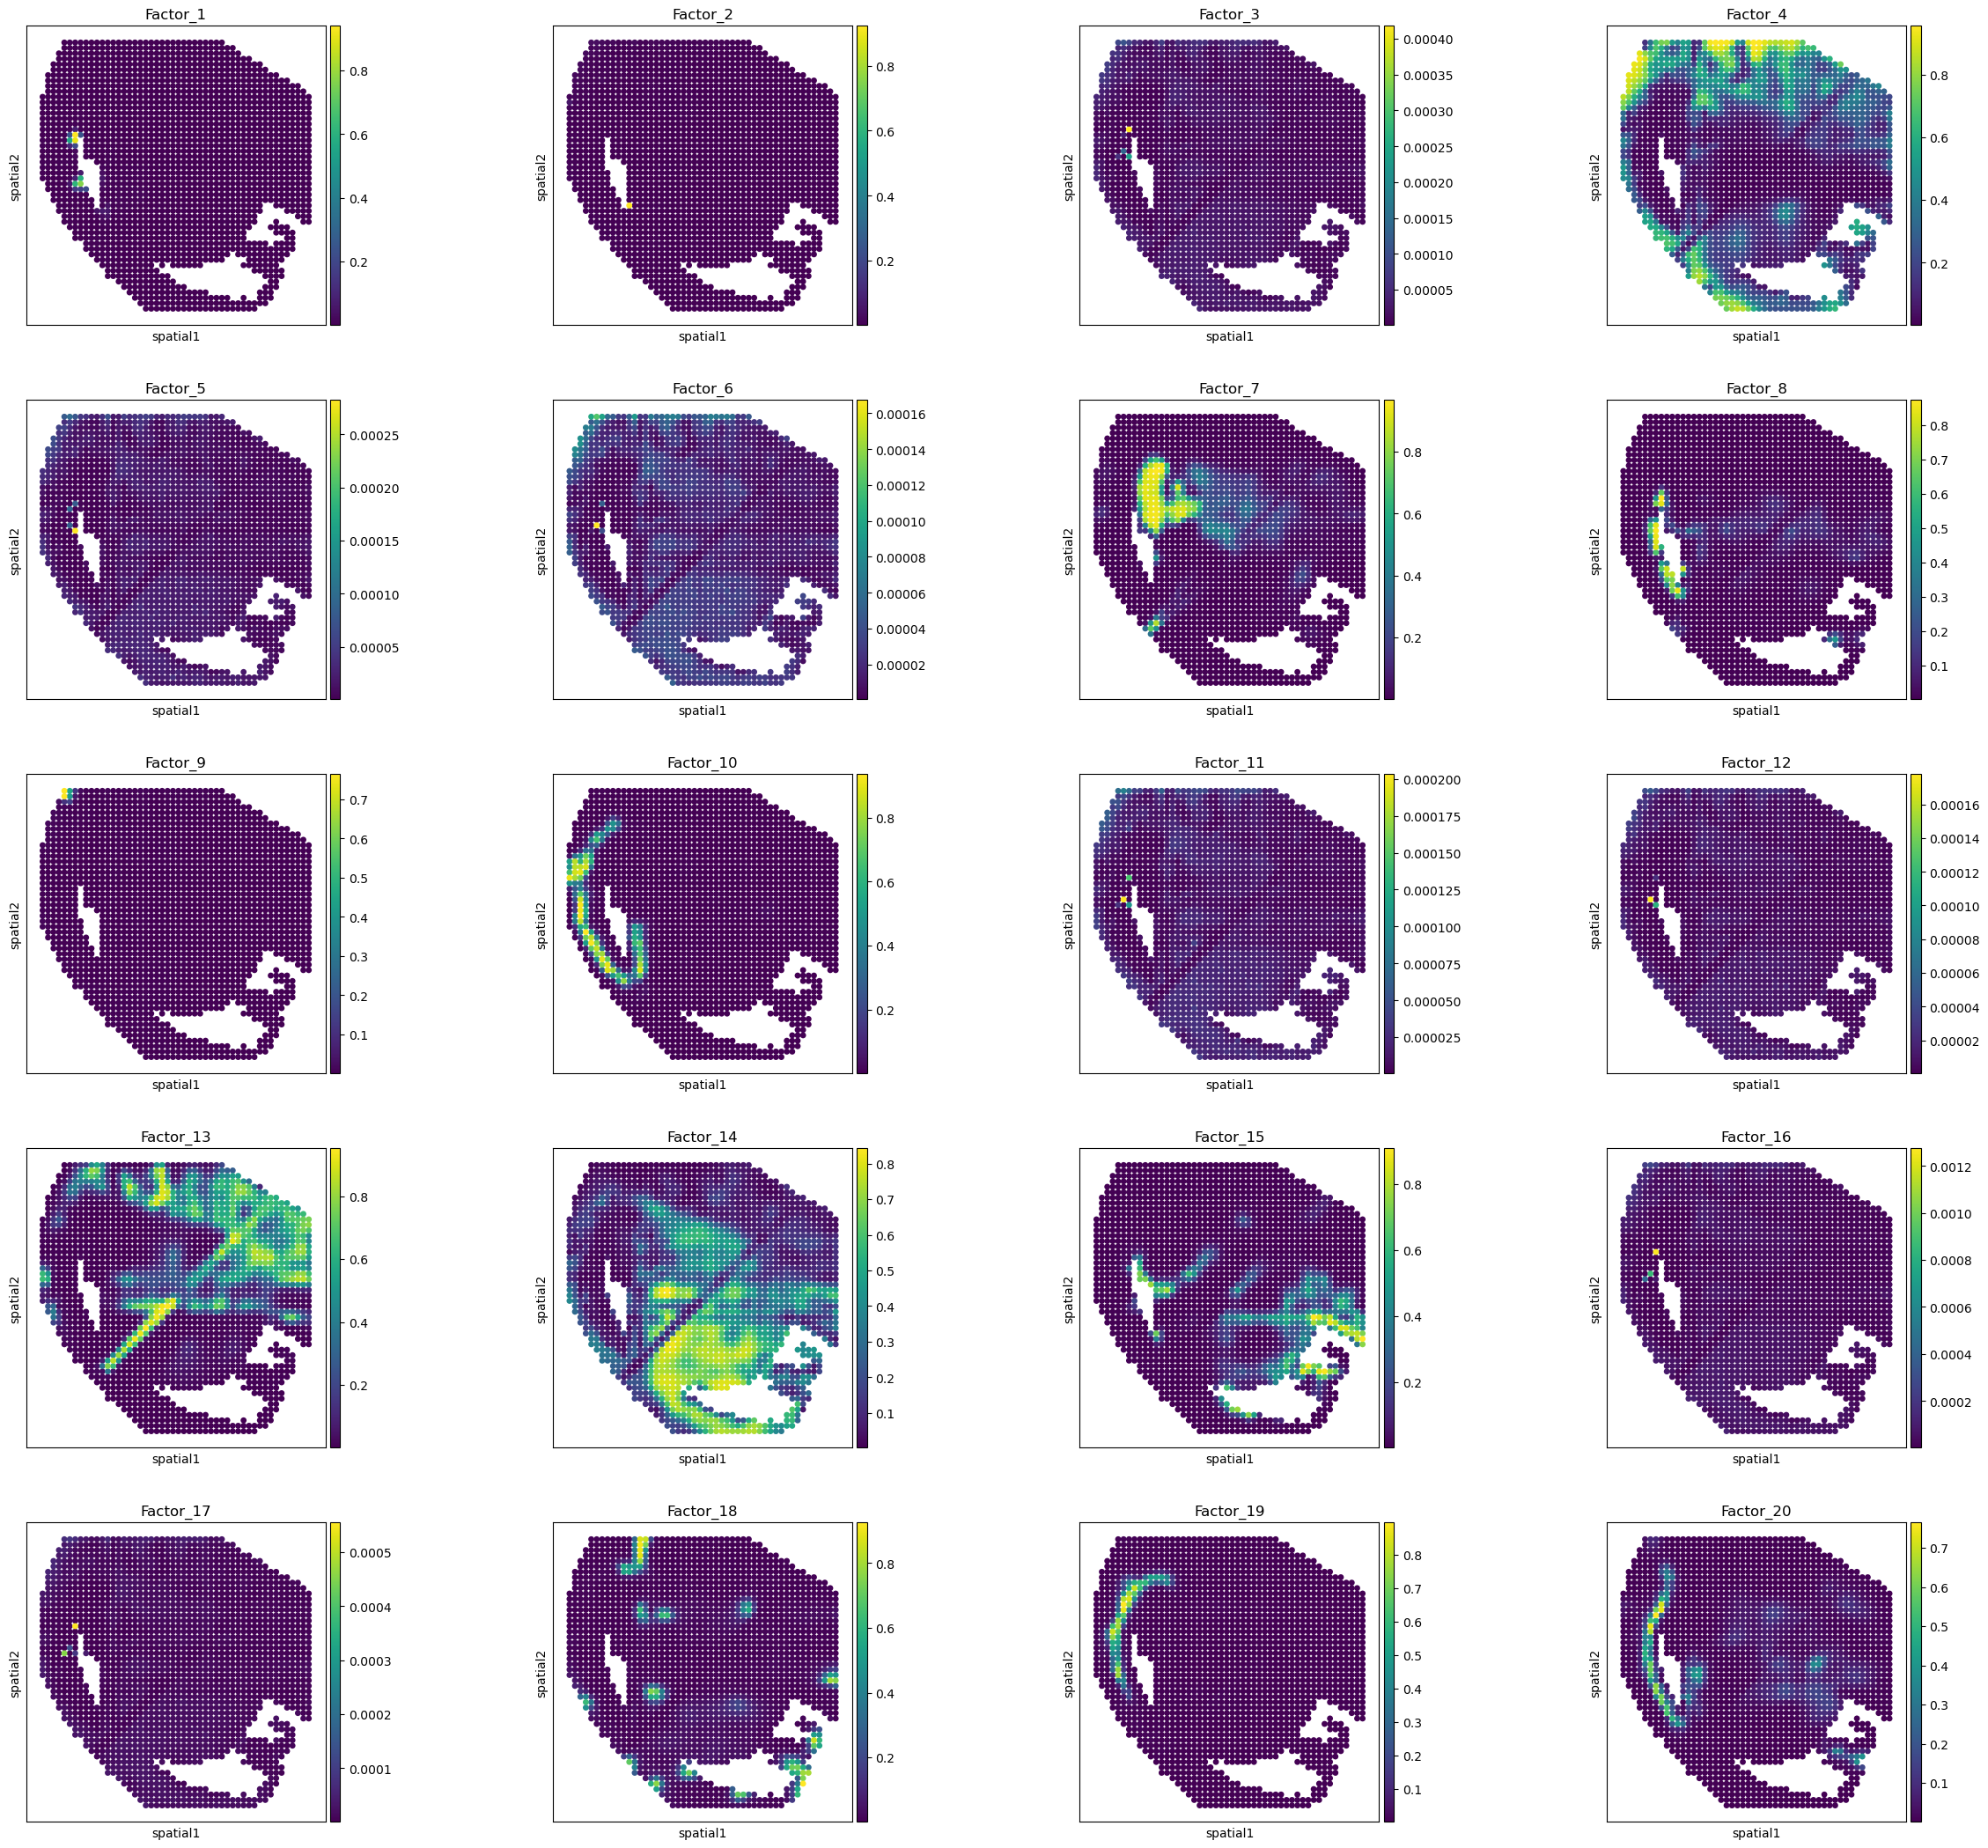

In [16]:
# # 创建图形并保存
# fig = sc.pl.spatial(
#     adata=adata1,
#     color=[f'Factor_{k+1}' for k in range(H_exp_np_normalized.shape[1])],
#     spot_size=0.1,
#     show=False  # 关键：不显示，只返回图形对象
# )

# # 保存图片
# plt.savefig('spatial_factors.png', 
#             dpi=300, 
#             bbox_inches='tight',  # 紧凑布局
#             facecolor='white')    # 背景色
# plt.close()  # 关闭图形，释放内存

sc.pl.spatial(
    adata=adata1,
    color=[f'Factor_{k+1}' for k in range(H_exp_np_normalized.shape[1])],
    spot_size=1.1)

In [20]:
adata1.obsm['latent'] = H_exp_np_normalized
sc.pp.neighbors(adata1, use_rep='latent')
sc.tl.leiden(adata1, resolution=0.2, key_added='leiden')

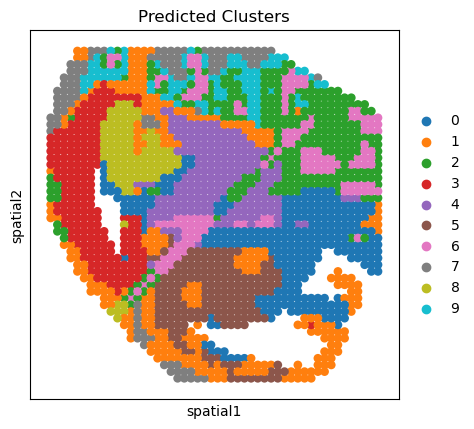

In [21]:
sc.pl.spatial(
    adata1,
    color="leiden",
    spot_size=1.3,
    title='Predicted Clusters'
)

<Axes: title={'center': 'UMAP'}, xlabel='UMAP1', ylabel='UMAP2'>

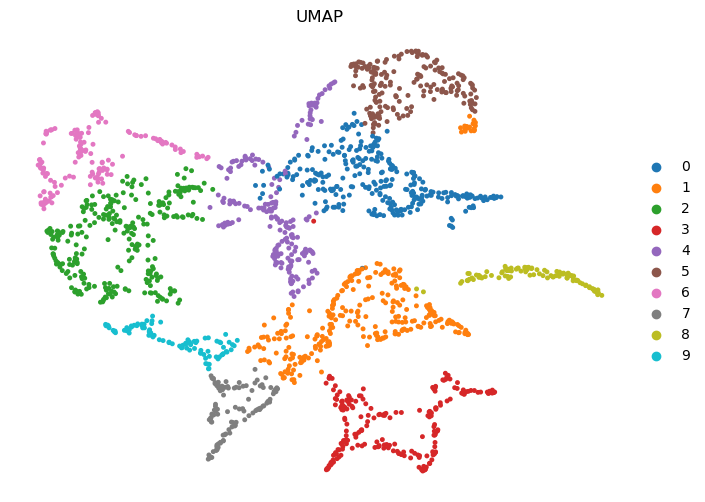

In [22]:
sc.tl.umap(adata1, random_state=42, min_dist=0.3)

# 4. 绘制UMAP图，用聚类结果着色
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sc.pl.umap(
    adata1,
    color='leiden',
    size=50,  # 点的大小
    title='UMAP',
    frameon=False,  # 不显示边框
    ax=ax,
    show=False
)

In [23]:
W_1 = model.get_W1_W2()[0].detach().cpu().numpy()
W_2 = model.get_W1_W2()[1].detach().cpu().numpy()
gene_names = adata1.var_names.tolist()
ad_names = adata2.var_names.tolist()  # 假设你的第二个模态的变量名

# 选择要可视化的因子
factor_indices = [3, 7, 9]  # Python是0-based索引
factor_names = ['Factor_4', 'Factor_8', 'Factor_10']

W_1_selected = W_1[factor_indices, :]  # 3 × n_genes
W_2_selected = W_2[factor_indices, :]  # 3 × n_peaks or n_ADTs


#normalization

row_sums_W1 = np.sum(W_1_selected, axis=1, keepdims=True)
W_1_selected = W_1_selected / row_sums_W1
row_sums_W2 = np.sum(W_2_selected, axis=1, keepdims=True)
W_2_selected = W_2_selected / row_sums_W2

In [24]:
import seaborn as sns
from scipy.interpolate import make_interp_spline

# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# 创建绘图函数 - 横向并排布局
def plot_factor_loadings_horizontal(W_matrix, var_names, factor_indices, factor_names, 
                                   modality_name="Gene", top_n=5, figsize=(15, 4)):
    """
    可视化因子载荷矩阵 - 横向并排布局
    标签放置策略：最大值标签在数据点正左侧，其他标签依次向下排列
    """
    
    num_factors = len(factor_indices)
    fig, axes = plt.subplots(1, num_factors, figsize=figsize, 
                            constrained_layout=True)
    
    # 确保axes是数组形式
    if num_factors == 1:
        axes = [axes]
    
    for idx, (factor_idx, factor_name, ax) in enumerate(zip(factor_indices, 
                                                           factor_names, 
                                                           axes)):
        # 获取当前因子的载荷向量
        factor_loadings = W_matrix[idx, :]
        
        # 按载荷值排序
        sorted_indices = np.argsort(factor_loadings)
        sorted_loadings = factor_loadings[sorted_indices]
        sorted_names = [var_names[i] for i in sorted_indices]
        
        # 生成平滑曲线
        x_original = np.arange(len(sorted_loadings))
        x_smooth = np.linspace(x_original.min(), x_original.max(), 300)
        
        # 使用B样条插值
        spl = make_interp_spline(x_original, sorted_loadings, k=1)
        y_smooth = spl(x_smooth)
        
        # 绘制平滑曲线
        ax.plot(x_smooth, y_smooth, linewidth=2, color='gray', alpha=0.8)
        
        # 找到最高表达的前top_n个点
        top_indices = sorted_indices[-top_n:]
        top_loadings = factor_loadings[top_indices]
        top_names = [var_names[i] for i in top_indices]
        top_positions = [np.where(sorted_indices == i)[0][0] for i in top_indices]
        
        # 按值排序（从高到低）
        sorted_top_data = sorted(zip(top_positions, top_loadings, top_names), 
                                key=lambda x: x[1], reverse=True)
        
        # 将排序后的数据重新分开
        sorted_top_positions = [x[0] for x in sorted_top_data]
        sorted_top_loadings = [x[1] for x in sorted_top_data]
        sorted_top_names = [x[2] for x in sorted_top_data]
        
        # 标注最高表达的点（空心圆圈）
        for pos, loading in zip(sorted_top_positions, sorted_top_loadings):
            ax.scatter(pos, loading, s=40, facecolors='none', 
                      edgecolors='red', linewidths=1, zorder=5)
        
        # 设置标签位置参数
        label_x_offset = -20  # 标签在数据点左侧20个点单位
        label_y_spacing = 10  # 标签之间的垂直间距
        line_offset = 2      # 连接线离数据点的距离
        
        # 为每个标签计算位置并添加
        for i, (pos, loading, name) in enumerate(zip(sorted_top_positions, 
                                                    sorted_top_loadings, 
                                                    sorted_top_names)):
            # 计算标签的y位置（第一个标签在数据点水平位置，后续标签依次向下）
            label_y = loading - (i * label_y_spacing)
            
            # # 绘制连接线（细线）
            # ax.plot([pos - line_offset, label_x_offset + 5],  # 线从数据点左侧到标签右侧
            #        [loading, label_y],  # 垂直位置
            #        color='gray', linewidth=0.8, alpha=0.6, linestyle='--')
            
            # 添加标签（在数据点左侧，垂直位置依次降低）
            ax.annotate(name,
                       xy=(pos, loading),  # 连接到数据点
                       xytext=(label_x_offset, label_y),  # 标签位置
                       textcoords='offset points',  # 使用点坐标
                       fontsize=8, 
                       ha='right',  # 右对齐（因为标签在数据点左侧）
                       va='center',  # 垂直居中
                       bbox=dict(boxstyle="round,pad=0.3", 
                               facecolor="white", 
                               edgecolor="red", 
                               alpha=0.8))
        
        # 添加图例说明
        # from matplotlib.lines import Line2D
        # legend_elements = [
        #     Line2D([0], [0], color='gray', lw=2, alpha=0.8, label='Smooth curve'),
        #     Line2D([0], [0], marker='o', color='w', markeredgecolor='red', 
        #           markersize=8, markerfacecolor='none', lw=1.5, label=f'Top {top_n}'),
        #     Line2D([0], [0], color='gray', lw=0.8, alpha=0.6, linestyle='--', label='Label connector')
        # ]
        # ax.legend(handles=legend_elements, loc='upper left', fontsize=7, framealpha=0.9)
        
        # 设置图形属性
        ax.set_title(f'{factor_name}', fontsize=10, fontweight='bold')
        ax.set_ylabel('Loading Value', fontsize=9)
        ax.set_xlabel('')  # 隐藏x轴标签
        ax.set_xticks([])  # 隐藏x轴刻度
        
        # 添加网格（只在y方向）
        ax.grid(True, axis='y', alpha=0.3, linestyle='--')
        
        # 设置y轴范围
        min_loading = np.min(factor_loadings)
        max_loading = np.max(factor_loadings)
        
        # 计算需要的y轴下限（考虑标签可能向下延伸）
        # 标签最多向下延伸：top_n * label_y_spacing
        max_label_extent = top_n * label_y_spacing
        data_height = max_loading - min_loading
        
        # 转换到数据坐标（如果标签间距是点单位，需要适当调整）
        # 这里使用简单的启发式方法
        y_bottom = max(0, min_loading - (max_label_extent * 0.01))  # 稍微向下扩展
        y_top = max_loading * 1.15  # 向上留出空间
        
        ax.set_ylim(bottom=y_bottom, top=y_top)
        
        # 设置x轴范围，为左侧标签留出空间
        x_margin_left = abs(label_x_offset) * 2  # 左侧留出标签空间
        x_margin_right = len(x_original) * 0.02  # 右侧少量空间
        ax.set_xlim(left=-x_margin_left, right=len(x_original) + x_margin_right)
        
    
    return fig, axes

Visualizing Gene modality (horizontal layout)...


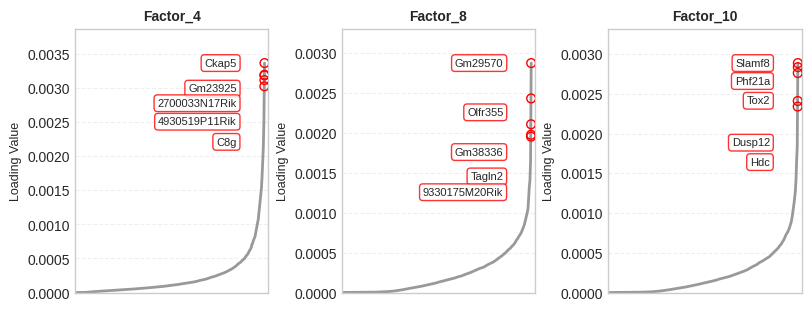


Visualizing ADT modality (horizontal layout)...


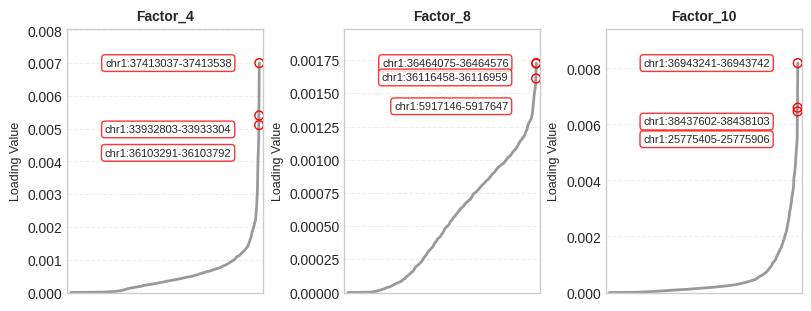

In [25]:
# 使用方法1：单个模态横向布局
print("Visualizing Gene modality (horizontal layout)...")
fig1, axes1 = plot_factor_loadings_horizontal(W_1_selected, gene_names, 
                                             range(len(factor_indices)), factor_names,
                                             modality_name="Gene", top_n=5, figsize=(8, 3))
plt.show()

print("\nVisualizing ADT modality (horizontal layout)...")
fig2, axes2 = plot_factor_loadings_horizontal(W_2_selected, ad_names, 
                                             range(len(factor_indices)), factor_names,
                                             modality_name="ADT", top_n=3, figsize=(8, 3))
plt.show()